In [51]:
import os
from collections import defaultdict

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import pearsonr, spearmanr

In [47]:
COUNTS_PATH = "../process_geuvadis_data/log_tpm/corrected_log_tpm.annot.csv.gz"
GENE_CLASS_PATH = "../finetuning/data/h5_bins_384_chrom_split/gene_class.csv"

PREDS_PATHS = {
    "TOP1": "preds/top1.csv",
    "LASSO": "preds/lasso.csv",
    "FUSION_ElasticNet": "preds/enet.csv",
    "FUSION_BLUP": "preds/blup.csv",
    "My_ElasticNet": "../predixcan_lite/h5_bins_384_chrom_split/384_bins_cv_train_only/preds.csv",
}

In [48]:
counts_df = pd.read_csv(COUNTS_PATH, index_col="our_gene_name")

class_df = pd.read_csv(GENE_CLASS_PATH, index_col=0)
random_split_genes = class_df[class_df["class"] == "random_split"].index.tolist()
population_split_genes = class_df[class_df["class"] == "yri_split"].index.tolist()

# Compute mean Pearson for all models

In [59]:
def compute_mean_pearson(
    counts_df: pd.DataFrame,
    preds_path: str,
    genes: list[str],
):
    corrs = []
    preds_df = pd.read_csv(preds_path, index_col=0)
    for gene in genes:
        preds = preds_df.loc[gene].dropna()
        counts = counts_df.loc[gene, preds.index]
        assert len(preds) == len(counts) == 77
        corr, _ = pearsonr(preds, counts)
        corr = np.nan_to_num(corr)
        corrs.append(corr)
    return np.mean(corrs)

In [60]:
results = defaultdict(list)
for model, preds_path in PREDS_PATHS.items():
    results["model"].append(model)
    results["gene_class"].append("random_split")
    results["corr"].append(
        compute_mean_pearson(counts_df, preds_path, random_split_genes)
    )

    results["model"].append(model)
    results["gene_class"].append("population_split")
    results["corr"].append(
        compute_mean_pearson(counts_df, preds_path, population_split_genes)
    )
results_df = pd.DataFrame(results)

/tmp/ipykernel_1990789/1373616837.py:12: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, _ = pearsonr(preds, counts)
/tmp/ipykernel_1990789/1373616837.py:12: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, _ = pearsonr(preds, counts)
/tmp/ipykernel_1990789/1373616837.py:12: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, _ = pearsonr(preds, counts)
/tmp/ipykernel_1990789/1373616837.py:12: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, _ = pearsonr(preds, counts)
/tmp/ipykernel_1990789/1373616837.py:12: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, _ = pearsonr(preds, counts)
/tmp/ipykernel_1990789/1373616837.py:12: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, _ 

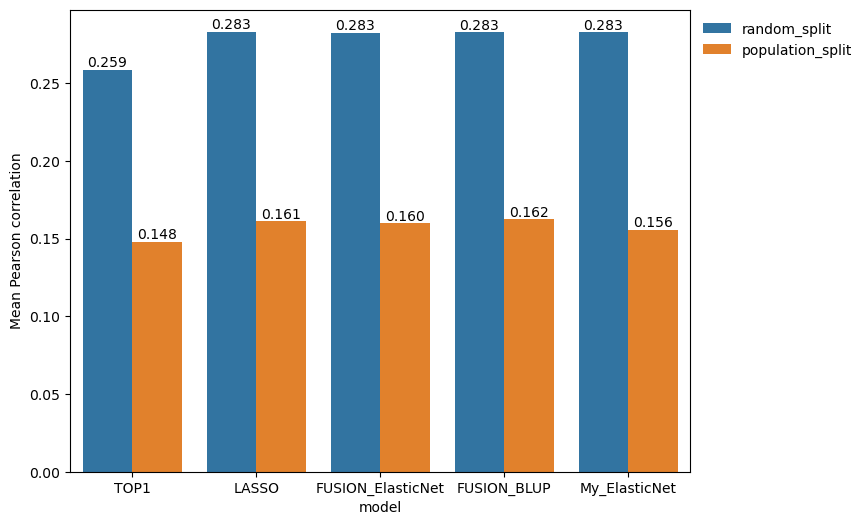

In [62]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.barplot(data=results_df, x="model", y="corr", hue="gene_class", ax=ax)
ax.set_ylabel("Mean Pearson correlation")

# Move legend outside of plot
plt.legend(loc="upper left", bbox_to_anchor=(1, 1), title="", frameon=False)

# Add values on top of bars
for container in ax.containers:
    ax.bar_label(container, fmt="%.3f", label_type="edge")

# Compare my ElasticNet to FUSION's

In [68]:
def compare_my_enet_to_fusion_enet(
    counts_df: pd.DataFrame,
    genes: list[str],
    fusion_enet_preds_path: str,
    my_enet_preds_path: str,
    ax: plt.Axes,
):
    def _compute_corr_per_gene(preds_path: str):
        preds_df = pd.read_csv(preds_path, index_col=0)
        corrs = {}
        for gene in genes:
            preds = preds_df.loc[gene].dropna()
            counts = counts_df.loc[gene, preds.index]
            assert len(preds) == len(counts) == 77
            corr, _ = pearsonr(preds, counts)
            corr = np.nan_to_num(corr)
            corrs[gene] = corr
        return corrs

    fusion_enet_corrs_map = _compute_corr_per_gene(fusion_enet_preds_path)
    fusion_enet_corrs_l = [fusion_enet_corrs_map[g] for g in genes]

    my_enet_corr_map = _compute_corr_per_gene(my_enet_preds_path)
    my_enet_corrs_l = [my_enet_corr_map[g] for g in genes]

    sns.scatterplot(x=my_enet_corrs_l, y=fusion_enet_corrs_l, ax=ax)
    ax.set_xlabel(
        "My ElasticNet Pearson corr."
        + "\n"
        + rf"($\mu = {np.mean(my_enet_corrs_l):.3f}$)"
    )
    ax.set_ylabel(
        "FUSION ElasticNet Pearson corr."
        + "\n"
        + rf"($\mu = {np.mean(fusion_enet_corrs_l):.3f}$)"
    )

    # Add y = x line
    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),
        np.max([ax.get_xlim(), ax.get_ylim()]),
    ]
    ax.plot(lims, lims, "k-", alpha=0.75, zorder=0)
    ax.set_aspect("equal", adjustable="box")
    ax.set_xlim(lims)
    ax.set_ylim(lims)

/tmp/ipykernel_1990789/2879637457.py:15: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, _ = pearsonr(preds, counts)
/tmp/ipykernel_1990789/2879637457.py:15: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, _ = pearsonr(preds, counts)
/tmp/ipykernel_1990789/2879637457.py:15: NearConstantInputWarning: An input array is nearly constant; the computed correlation coefficient may be inaccurate.
  corr, _ = pearsonr(preds, counts)
/tmp/ipykernel_1990789/2879637457.py:15: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, _ = pearsonr(preds, counts)
/tmp/ipykernel_1990789/2879637457.py:15: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, _ = pearsonr(preds, counts)
/tmp/ipykernel_1990789/2879637457.py:15: NearConstantInputWarning: An input array is nearly constant; the computed correla

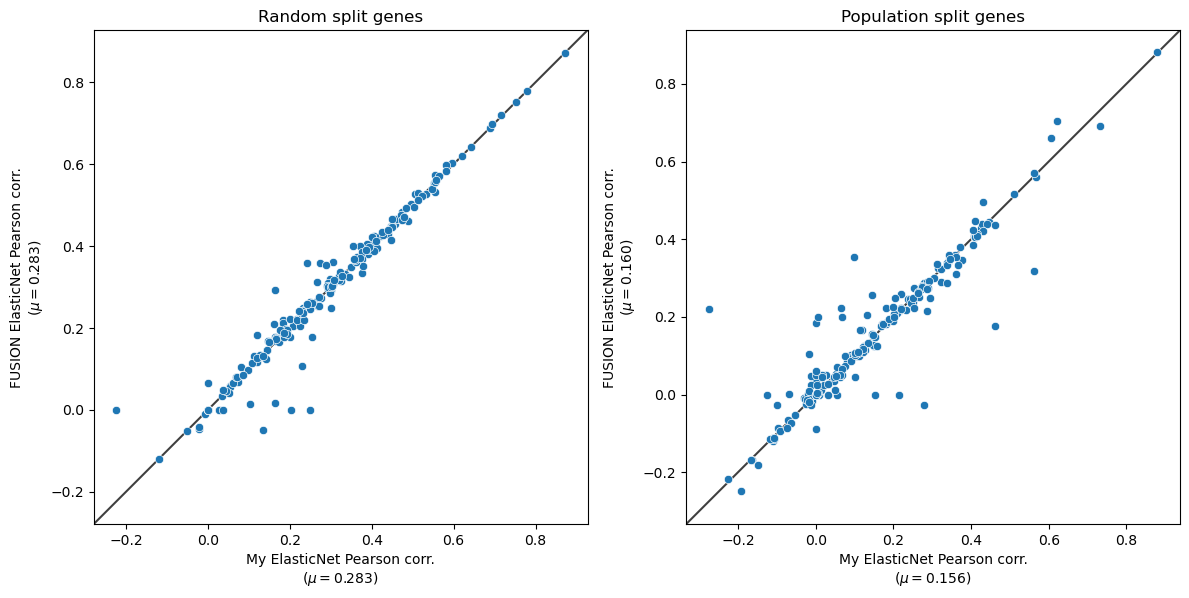

In [69]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
compare_my_enet_to_fusion_enet(
    counts_df,
    random_split_genes,
    PREDS_PATHS["FUSION_ElasticNet"],
    PREDS_PATHS["My_ElasticNet"],
    axs[0],
)
axs[0].set_title("Random split genes")

compare_my_enet_to_fusion_enet(
    counts_df,
    population_split_genes,
    PREDS_PATHS["FUSION_ElasticNet"],
    PREDS_PATHS["My_ElasticNet"],
    axs[1],
)
axs[1].set_title("Population split genes")

plt.tight_layout()
plt.show()